# Implementing MACD indicator

## Prepare funtions used throughout the analysis


### Import all the necessery libraries

In [1]:
%matplotlib inline

from IPython.display import display, Math, Latex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 14,8

### Funtions that round up value to multiple of step

In [2]:
def round_down(value, step):
    return value//step*step
def round_up(value, step):
    return (value+step-1)//step*step

### Funtions to calculate Exponentially Moving Average

$$EMA_{N} = \dfrac {p_{0} + (1-\alpha ) p_{1} + (1-\alpha)^2 p_{2} + ... + (1 - \alpha)^N  p_{N} }{1 + (1-\alpha)+ (1-\alpha)^2 +...+ (1-\alpha)^N}
$$
$$\textrm{Where:}$$

$$\alpha = \dfrac{2}{N+1}$$
$$p_{N} \textrm{- the sample from N days before }$$
$$N \textrm{- number of samples }$$


In [3]:
def ema(series, n):
    emaSeries = pd.Series(dtype=float)
    for i in range(len(series)):
        date = series.index[i]
        value = series.iloc[i]
        if i < n:
            newRow = pd.Series(float('NaN'), index=[date])
            emaSeries = pd.concat([emaSeries, newRow])
        else:
            alfa = 2/(n+1)
            # (1 - alfa) to j power
            oneMinAlfaJ = 1
            numerator = value
            denumerator = oneMinAlfaJ
            for j in range(1, n+1):
                oneMinAlfaJ *= (1-alfa)
                valueJBef = series.iloc[i-j]
                numerator += oneMinAlfaJ * valueJBef
                denumerator += oneMinAlfaJ
                
            newRow = pd.Series(numerator/denumerator, index=[date])
            emaSeries = pd.concat([emaSeries, newRow])
            
    return emaSeries

### Funtions to find crossovers of MACD and SIGNAL

As an input they take np.DataFrame with 'Date' as an index and columns 'Value', MACD indicator 'MACD' and signal indicator 'SIGNAL'.
As an output they return np.DataFrame with rows where MACD became greater than SIGNAL or the other way around.

In [4]:
def get_points_MACD_gr_SIG(cdpr):
    previousMACD = cdpr['MACD'].shift(1)
    previousSIG = cdpr['SIGNAL'].shift(1)
    crossing = ((cdpr['MACD'] >= cdpr['SIGNAL']) & (previousMACD < previousSIG))
    crossing_dates = cdpr.loc[crossing]
    return crossing_dates

def get_points_SIG_gr_MACD(cdpr):
    previousMACD = cdpr['MACD'].shift(1)
    previousSIG = cdpr['SIGNAL'].shift(1)
    crossing = ((cdpr['MACD'] <= cdpr['SIGNAL']) & (previousMACD > previousSIG))
    crossing_dates = cdpr.loc[crossing]
    return crossing_dates

## Read and analyze data

### Read csv file with 1000 rows of data about CD Projekt Red. Select only the necessery columns.

cdpr is the DataFrame with information about share prices of CD Projekt Red

In [5]:
cdpr = pd.read_csv('cdr_d.csv', index_col='Date')
cdpr = cdpr[['Open']].tail(1000)

### Calculating MACD and SIGNAL

$$MACD = EMA_{12} - EMA_{26} \textrm { (calculated from shares prices)}$$

$$ SIGNAL = EMA_{9} \textrm { (calculated from MACD)}$$


In [6]:
ema12 = ema(cdpr['Open'], 12)
ema26 = ema(cdpr['Open'], 26)
cdpr['MACD'] = ema12 - ema26
cdpr['SIGNAL'] = ema(cdpr['MACD'], 9)

### Plotting prices of shares

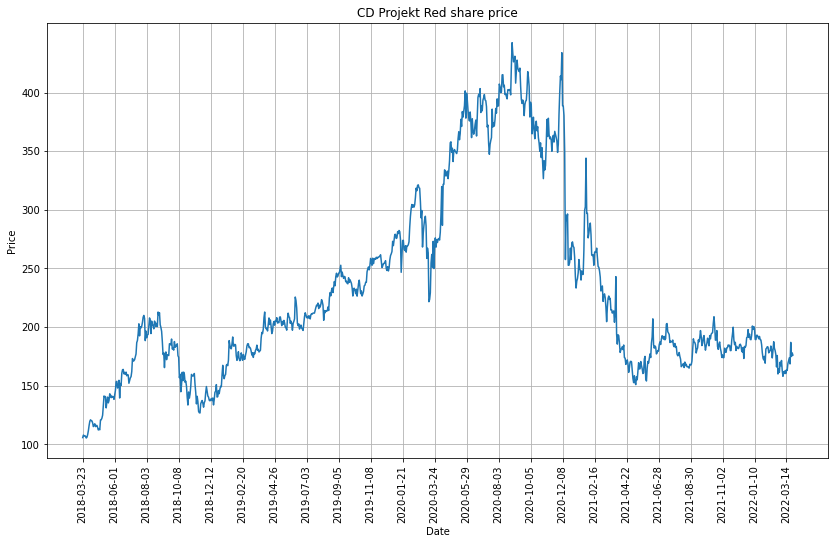

In [13]:
plt.plot(cdpr.index, cdpr['Open'])
xticks = cdpr.index[::45]
plt.xticks(xticks)
plt.xticks(rotation=90)

minY = int(cdpr['Open'].min())
maxY = int(cdpr['Open'].max())
yticksList = list(range(round_down(minY,50),round_up(maxY,50), 50))
plt.yticks(yticksList)

plt.grid(True)

plt.title('CD Projekt Red share price')
plt.xlabel('Date')
plt.ylabel('Price')

plt.show()


### Getting points where MACD becomes grater than SIGNAL and the other way around

In [8]:
dates_MACD_gr_SIG = get_points_MACD_gr_SIG(cdpr)
dates_SIG_gr_MACD = get_points_SIG_gr_MACD(cdpr)

### Ploting these points

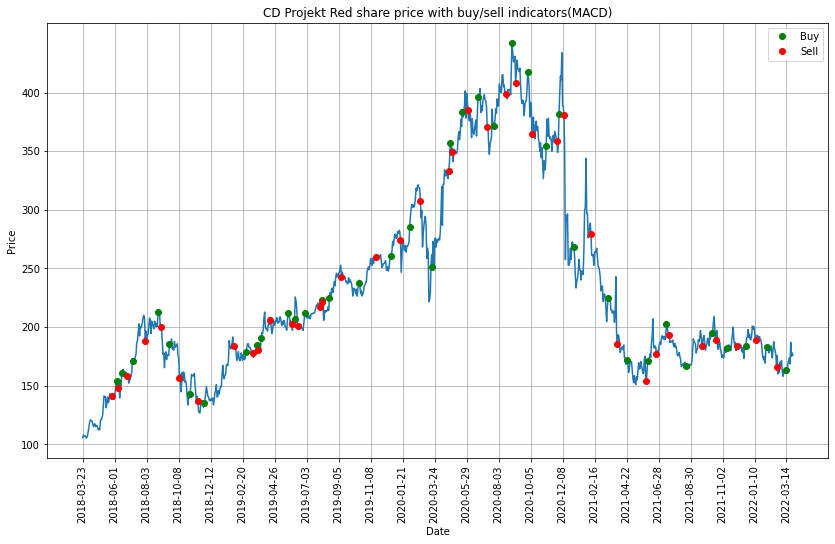

In [9]:
plt.plot(cdpr.index, cdpr['Open'])
plt.plot(dates_MACD_gr_SIG.index, dates_MACD_gr_SIG['Open'], 'go', markersize=6, label='Buy')
plt.plot(dates_SIG_gr_MACD.index, dates_SIG_gr_MACD['Open'], 'ro', markersize=6, label='Sell')
xticks = cdpr.index[::45]
plt.xticks(xticks)
plt.xticks(rotation=90)

minY = int(cdpr['Open'].min())
maxY = int(cdpr['Open'].max())
yticksList = list(range(round_down(minY,50),round_up(maxY,50), 50))
plt.yticks(yticksList)

plt.grid(True)

plt.title('CD Projekt Red share price with buy/sell indicators(MACD)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

### Plotting MACD & SIGNAL

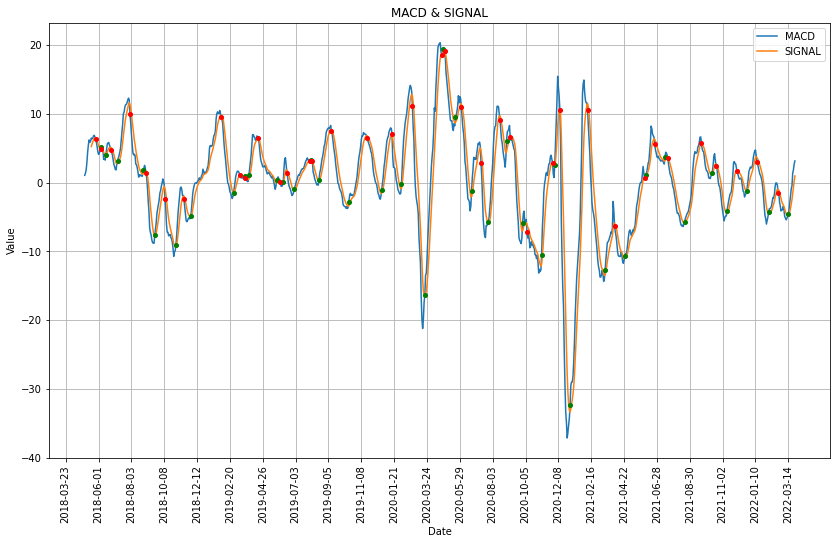

In [10]:
plt.plot(cdpr.index, cdpr['MACD'], label='MACD')
plt.plot(cdpr.index, cdpr['SIGNAL'], label='SIGNAL')
plt.plot(dates_MACD_gr_SIG.index, dates_MACD_gr_SIG['MACD'], 'go', markersize=4)
plt.plot(dates_SIG_gr_MACD.index, dates_SIG_gr_MACD['MACD'], 'ro', markersize=4)
plt.xticks(xticks)
plt.xticks(rotation=90)

plt.grid(True)

plt.title('MACD & SIGNAL')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

plt.show()

## MACD is useful for technical analysis

MACD by it's nature is great at indicating buying/selling after steep and steady growth but when there is quick change the indicator can be late and not show the real trend. As we can see it sometimes tells you to buy shares when the price is at local maximum and sell at local minimum. But by following MACD you can gain money when there is gonna be a big raise in price and also save money when there is gonna be a big decrease in price. 

# Automatic buying/selling algorithm

Investors have different ways to decide when to buy or sell shares but the income is calculated the same way.
Income is the ratio of all the money at the beginning to all the money he has at the and.

$$Income_{date} = \dfrac{Money_{date}}{Money_{begginingSimul}}$$
Where:
$$Money\textrm{ - all money he has in wallet and the value of shares at given moment}$$

## Naive investor

Naive investor will buy as many shares as he can when MACD crosses SIGNAL from beneath and sell all shares when MACD corsses SIGNAL from above.

### Implementation of the naive investor

In [11]:
class NaiveInvestor:
    def __init__(self, startingMoney, startingShares):
        self.startingMoney = startingMoney
        self.startingMoneyInShares = startingShares * cdpr.loc[cdpr.index[0], 'Open']
        self.money=startingMoney
        self.shares= startingShares
        self.incomeOverTime = pd.Series(dtype=float)
    def simulate(self):
        for date in cdpr.index:
            if date in dates_MACD_gr_SIG.index:
                self.buyMax(cdpr.loc[date, 'Open'])
            elif date in dates_SIG_gr_MACD.index:
                self.sellMax(cdpr.loc[date, 'Open'])
            newRow = pd.Series(self.calcIncome(date), index=[date])
            self.incomeOverTime = pd.concat([self.incomeOverTime, newRow])
                
    def buyMax(self, price):
        numBuyingShares = self.money // price
        self.money -= numBuyingShares * price
        self.shares += numBuyingShares
        
    def sellMax(self, price):
        self.money += self.shares * price
        self.shares = 0
    
    def calcIncome(self, date):
        moneyInStock = self.shares * cdpr.loc[date, 'Open']
        return (self.money+moneyInStock)/(self.startingMoney + self.startingMoneyInShares)
    
    def getIncomeOverTime(self):
        return self.incomeOverTime
    
    


### Running simulation

Investor will start with 1000 PLN and 0 shares of CD Projekt Red.
The income over time will be shown on graph.

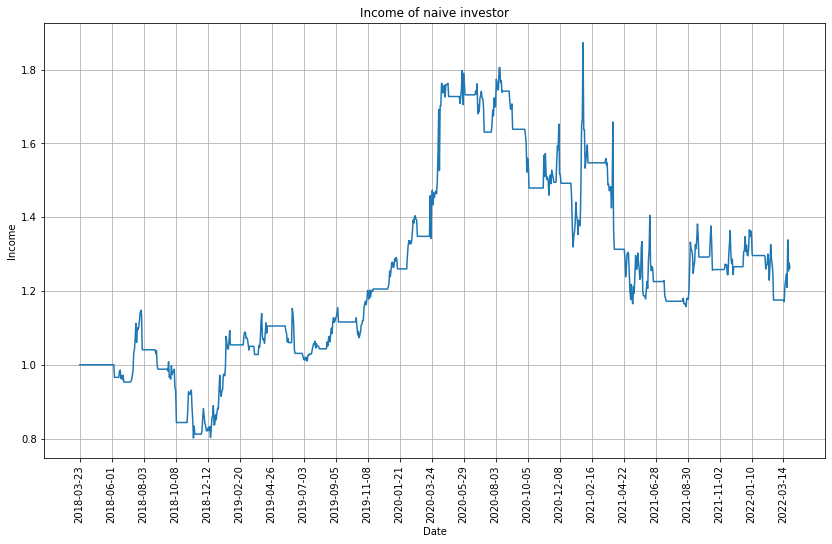

In [12]:
investor = NaiveInvestor(1000, 0);
investor.simulate()    
incomeOverTime = investor.getIncomeOverTime()

plt.plot(incomeOverTime)
plt.xticks(xticks)
plt.xticks(rotation=90)

plt.grid(True)

plt.title('Income of naive investor')
plt.xlabel('Date')
plt.ylabel('Income')


plt.show()

### Analyzing naive investor's income

As we can see on the graph the price quadrupled at one moment and investor did not double the money he had. He managed to have the income at 1.3 level only because prices were all the time at the level higher then at the beggining. There has been bigger potential to make money. Limiting yourself just to MACD is not the best idea when investing. Just because this ivestor multiplied his money by 1.3 does not mean this strategy is advisable.